In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

#Exploratory Data Analysis

In [4]:
YearDat = pd.read_csv('YearDat.csv')
MonthDat = pd.read_csv('MonthDat.csv')
SeasonDat = pd.read_csv('SeasonDat.csv')

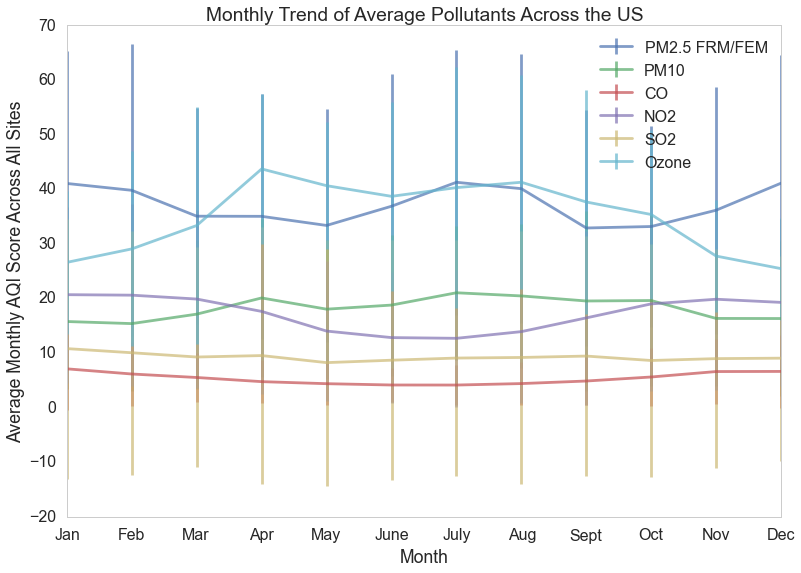

In [5]:
#Visualize the average pollutants monthly
group = MonthDat.groupby('month')
plotVals = group.mean()
plotError = group.std()
fig, ax1 = plt.subplots()
plt.locator_params(nbins=12)
plt.grid(False)
plt.errorbar(plotVals.index,plotVals.AQI_PM25_FRMFEM, yerr=2*plotError.AQI_PM25_FRMFEM,label='PM2.5 FRM/FEM',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_PM10, yerr=2*plotError.AQI_PM10,label='PM10',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_CO, yerr=2*plotError.AQI_CO,label='CO',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_NO2, yerr=2*plotError.AQI_NO2,label='NO2',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_SO2, yerr=2*plotError.AQI_SO2,label='SO2',alpha=.7)
plt.errorbar(plotVals.index,plotVals.AQI_OZONE, yerr=2*plotError.AQI_OZONE,label='Ozone',alpha=.7)
ax1.set_xticklabels(('Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'))
ax1.set_xlabel('Month')
ax1.set_ylabel("Average Monthly AQI Score Across All Sites")
ax1.legend(loc='upper right')
plt.title('Monthly Trend of Average Pollutants Across the US')

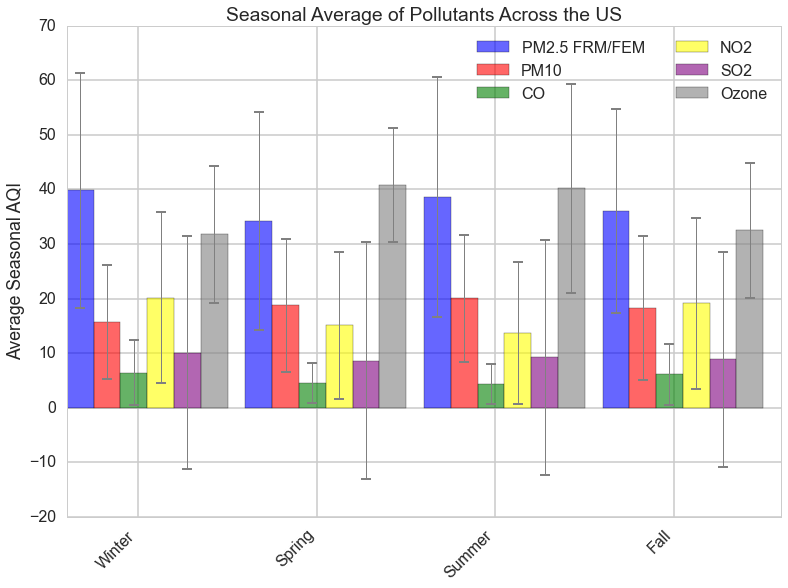

In [6]:
#Visualize the average pollutants by season
group = SeasonDat.groupby('season')
plotVals = group.mean()
plotError = group.std()
fig, ax1 = plt.subplots()
x=[0,1,2,3]
pm25_bar=plt.bar(x,[float(plotVals[plotVals.index=='Winter']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Fall']['AQI_PM25_FRMFEM'])],
                  width=.15,color='blue',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_PM25_FRMFEM']),2*float(plotError[plotError.index=='Spring']['AQI_PM25_FRMFEM']),
 2*float(plotError[plotError.index=='Summer']['AQI_PM25_FRMFEM']),2*float(plotError[plotError.index=='Fall']['AQI_PM25_FRMFEM'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

pm10_bar=plt.bar([i+.15 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_PM10']),float(plotVals[plotVals.index=='Spring']['AQI_PM10']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM10']),float(plotVals[plotVals.index=='Fall']['AQI_PM10'])],
                  width=.15,color='red',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_PM10']),2*float(plotError[plotError.index=='Spring']['AQI_PM10']),
 2*float(plotError[plotError.index=='Summer']['AQI_PM10']),2*float(plotError[plotError.index=='Fall']['AQI_PM10'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

co_bar=plt.bar([i+.3 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_CO']),float(plotVals[plotVals.index=='Spring']['AQI_CO']),
 float(plotVals[plotVals.index=='Summer']['AQI_CO']),float(plotVals[plotVals.index=='Fall']['AQI_CO'])],
                  width=.15,color='green',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_CO']),2*float(plotError[plotError.index=='Spring']['AQI_CO']),
 2*float(plotError[plotError.index=='Summer']['AQI_CO']),2*float(plotError[plotError.index=='Fall']['AQI_CO'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

no2_bar=plt.bar([i+.45 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_NO2']),float(plotVals[plotVals.index=='Spring']['AQI_NO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_NO2']),float(plotVals[plotVals.index=='Fall']['AQI_NO2'])],
                  width=.15,color='yellow',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_NO2']),2*float(plotError[plotError.index=='Spring']['AQI_NO2']),
 2*float(plotError[plotError.index=='Summer']['AQI_NO2']),2*float(plotError[plotError.index=='Fall']['AQI_NO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

so2_bar=plt.bar([i+.6 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_SO2']),float(plotVals[plotVals.index=='Spring']['AQI_SO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_SO2']),float(plotVals[plotVals.index=='Fall']['AQI_SO2'])],
                  width=.15,color='purple',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_SO2']),2*float(plotError[plotError.index=='Spring']['AQI_SO2']),
 2*float(plotError[plotError.index=='Summer']['AQI_SO2']),2*float(plotError[plotError.index=='Fall']['AQI_SO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

ozone_bar=plt.bar([i+.75 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_OZONE']),float(plotVals[plotVals.index=='Spring']['AQI_OZONE']),
 float(plotVals[plotVals.index=='Summer']['AQI_OZONE']),float(plotVals[plotVals.index=='Fall']['AQI_OZONE'])],
                  width=.15,color='grey',alpha=.6,yerr=[2*float(plotError[plotError.index=='Winter']['AQI_OZONE']),2*float(plotError[plotError.index=='Spring']['AQI_OZONE']),
 2*float(plotError[plotError.index=='Summer']['AQI_OZONE']),2*float(plotError[plotError.index=='Fall']['AQI_OZONE'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

plt.xticks([i+.4 for i in x],['Winter','Spring','Summer','Fall'],rotation=45,ha='right')
ax1.set_ylim(-20,70)
plt.ylabel('Average Seasonal AQI')
plt.legend((pm25_bar,pm10_bar,co_bar,no2_bar,so2_bar,ozone_bar),('PM2.5 FRM/FEM','PM10','CO','NO2','SO2','Ozone'),ncol=2)
plt.title('Seasonal Average of Pollutants Across the US')

C:\Users\Mark\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


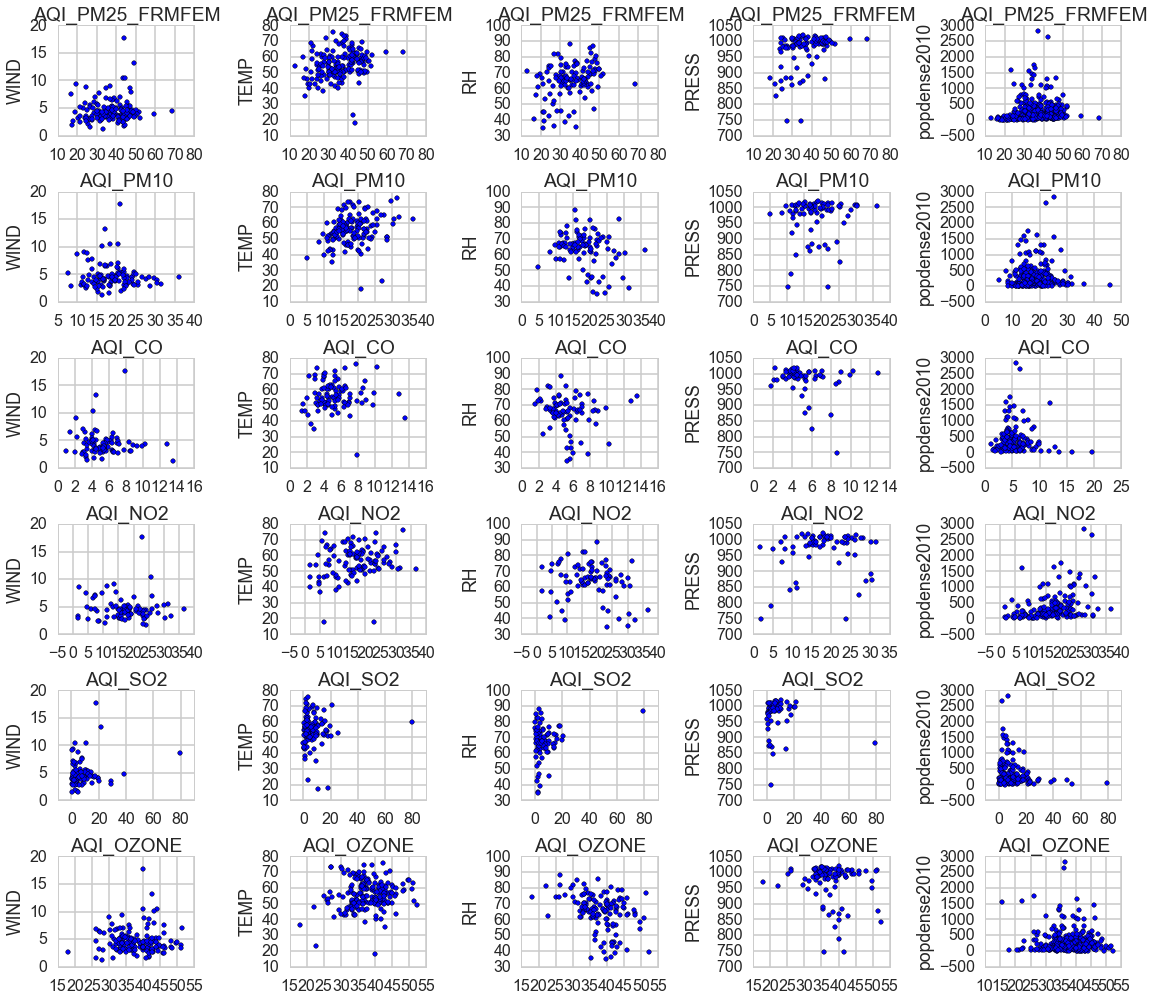

In [7]:
outcomes = ['AQI_PM25_FRMFEM',"AQI_PM10","AQI_CO","AQI_NO2",'AQI_SO2','AQI_OZONE']
predictors = ['WIND','TEMP','RH','PRESS','popdense2010']
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 14), 
                         tight_layout=True)
count = 0
for pol in outcomes:
    for pred in predictors:
        ax = axes.ravel()[count]
        plotting_dat = YearDat[[pol,pred]]
        ax.scatter(plotting_dat[pol],plotting_dat[pred])
        count += 1
        ax.set_title(pol)
        ax.set_ylabel(pred)
        #ax.annotate(pol, xy=(np.min(plotting_dat[pol]), np.max(plotting_dat[pred])), fontsize=14)